In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift, dct
import sklearn as sk
import scipy as sc
import scipy.signal as scp
import numpy.random as rnd
from scipy.io import wavfile
from IPython.display import Audio
import noisereduce as nr

import os

In [11]:
# Variables
data_path = "./data/1/"
fs = 48000

In [16]:
# Utility Functions

def iterate_all(root, function):
    """
    Apply function to all files under root
    returns 1 if succesfull, -1 if not.
    """
    for dirpath, dirnames, filenames in os.walk(root):
        for filename in filenames:
            t, signal = function(f"{dirpath}/{filename}")
            print(len(signal))
            
    return 1;

def generate_noisy(data, ratio):
    """
    Generate noisy variant of data.
    noise is additive and normally distributed
    """
    return data + rnd.normal(0,1,len(data)) * max(abs(data)) * ratio

def clean_data(data):
    """
    remove silent spaces and noise
    """
    return data[abs(data) > abs(data).mean()*0.05]
    
def read_wav(path):
    """
    Reads wav file
    Returns time and signal vectors
    """
    fs, signal = wavfile.read(path)
    t = np.arange(0,len(signal)/fs, 1/fs)
    return [t, signal]

def remove_noise(data):
    """
    Simple function to remove the noise from the signal data
    """
    return nr.reduce_noise(y=data, sr=fs)
        

In [17]:
# Feature extraction functions
# http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

def mel(f):
    """
    Transform to mel space
    """ 
    return 1125*np.log(1+f/700)

def imel(m):
    """
    Transform from mel space to frequency domain
    """
    return 700*(np.exp(m/1125) - 1)

def MFCC(signal, fs):
    """
    HAS TO BE DEBUGGED
    Compute mel frequency coefficients
    """
    # compute spectrum for frames of 25 ms with 10 ms overlaps
    Nfft = 2048
    f, t, Z = stft(x=signal, fs=fs, window='hann', nperseg=fs*25e-3, noverlap=fs*10e-3, nfft=Nfft)
    Nf = len(t) # number of frames in signal
    Ncut = int(np.ceil(Nfft/6)) # 342 point spectrum
    # turn each FFT window into power spectrum by scaling
    P = np.zeros((Nf,Ncut))
    for n in range(Nf):
        Fcut = Z[:Ncut,n] # compute the 342 point power spectrum
        P[n] = abs(Fcut)**2/Ncut
    
    # upper and lower frequency bounds in Hz converted to Mel scale
    upperHz = 8000
    lowerHz = 300
    upperMel = mel(upperHz)
    lowerMel = mel(lowerHz)
    m = np.linspace(lowerMel,upperMel,28) # mel filterbank
    h = imel(m) # filterbank in frequency domain
    f = np.floor((Nfft+1)*h/fs) # filterbank as FFT bin indices
    f = f.astype(int)
    
    # construct filters in filterbank
    mfilters = np.zeros((26,342))
    for n in range(26):
        for i in range(len(f)):
            if i != 0 and i != len(f)-1:
                for iless in range(f[i]-f[i-1]):
                    mfilters[n,f[i-1]+iless] = iless/(f[i]-f[i-1])
                for imore in range(f[i+1]-f[i]):
                    mfilters[n,f[i]+imore] = 1-imore/(f[i+1]-f[i])
    
    M = np.zeros((Nf,26))
    # filter data with filterbank
    for n in range(Nf):
        for c in range(26):
            M[n,c] = sum(mfilters[c]*P[n])
    
    # take the log discrete cosine transform of frame spectra
    mfcc = np.zeros((Nf,26))
    for n in range(Nf):
        mfcc[n] = dct(np.log(M[n]))
    
    # return ndarray with rows representing timeframes and 
    return mfcc


/tmp/ipykernel_178/4098889102.py:33: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(path)


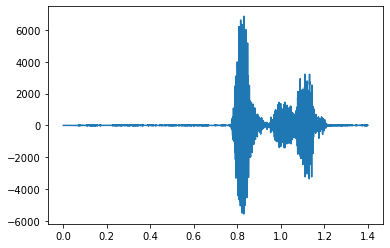

In [18]:

t, signal = read_wav(data_path + "yksi.wav")

plt.plot(t,signal)
plt.show()

In [30]:
plt.show()
read_wav(data_path + "yksi.wav")
noisy = generate_noisy(signal, 0.01)
Audio(noisy, rate=fs)

/tmp/ipykernel_178/4098889102.py:33: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(path)


In [31]:
reduced = remove_noise(noisy)
Audio(reduced, rate=fs)

In [22]:
a = MFCC(signal,fs)
np.size(a,0)

95

In [23]:
np.size(a,1)

26

In [24]:
np.size(signal,0)

67142

In [25]:
np.size(signal,1)

IndexError: tuple index out of range